# Gradient Boosting Classifier
I got XGBoost recommended to use as classifier, so let's see what it gives. Appearantly, more than half of the Kaggle competitions are won using this method. More explanation about Gradient boosting classifiers can be found [here](https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance/notebook), [here](https://www.analyticsvidhya.com/blog/2016/01/gradient-boosting-algorithm-machine-learning/) or in [this paper](https://jerryfriedman.su.domains/ftp/trebst.pdf).
The sklearn documentation of the sklearn GradientBoostingClassifier can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). XGBoost itself has [it's own library](https://xgboost.readthedocs.io/en/stable/python/python_api.html).


In [1]:
from util import get_wpm_train_test, fit_predict_print_wp
from sklearn.ensemble import GradientBoostingClassifier

train_x, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True)
model = GradientBoostingClassifier(random_state=42)

fit_predict_print_wp(model, train_x, train_y, test_x, test_y)

Accuracy: 53.30% (97/182)


The results are not better than the previousmodels, so let's immediately try xgboost to see if it can do better.

In [8]:
from sklearn.model_selection import GroupKFold
from xgboost import XGBClassifier

params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'alpha': 10,
    'learning_rate': 1.0,
    'n_estimators': 100
}

model = XGBClassifier(random_state=42)
fit_predict_print_wp(model, train_x, train_y, test_x, test_y)

Accuracy: 54.40% (98/182)


This gives a slight improvement, but still not better than our naïve bayes clssifier. Let's try some hyperparameters. I'll follow [this](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook) guide. While following the xgboost intuition explanation [here](https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance/notebook), some sample parameteres where used in the article that I wanted to test, and they already gave better restults:


In [12]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'alpha': 10,
    'learning_rate': 1.0,
    'n_estimators': 100
}

model = XGBClassifier(random_state=42, **params)
fit_predict_print_wp(model, train_x, train_y, test_x, test_y)

Accuracy: 56.59% (103/182)


In [20]:
from util import get_manually_labeled_features, predict_wp, evaluate_wp
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
         'gamma': hp.uniform('gamma', 1, 9),
         'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
         'reg_lambda': hp.uniform('reg_lambda', 0, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
         'n_estimators': 180,
         'seed': 42
         }

group_kfold = GroupKFold(n_splits=2)

train_x.reset_index(drop=True, inplace=True) # Not sure whether this is necessarily
train_y.reset_index(drop=True, inplace=True)

train_index, test_index = next(group_kfold.split(train_x, train_y, groups=groups))
train_x_, train_y_ = train_x.iloc[train_index], train_y.iloc[train_index]
val_x, val_y = train_x.iloc[test_index], train_y.iloc[test_index]

def objective(space):
    model = xgb.XGBClassifier(
        n_estimators=space['n_estimators'], max_depth=int(space['max_depth']), gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']), min_child_weight=int(space['min_child_weight']),
        colsample_bytree=int(space['colsample_bytree']))

    model.fit(get_manually_labeled_features(train_x_), train_y_['Winner'], groups)
    predicted_winners = predict_wp(model, val_x)
    accuracy = evaluate_wp(val_y, predicted_winners)

    print(f"Accuracy: {accuracy} for parameters {space}")

    return {'loss': -accuracy, 'status': STATUS_OK}

trials = Trials()

best_params = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
best_params

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(

job exception: [16:38:48] C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/data/data.cc:735: Check failed: weights_.Size() == num_row_ (1804 vs. 901) : Size of weights must equal to number of rows.



  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


XGBoostError: [16:38:48] C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/data/data.cc:735: Check failed: weights_.Size() == num_row_ (1804 vs. 901) : Size of weights must equal to number of rows.

## Feature importance

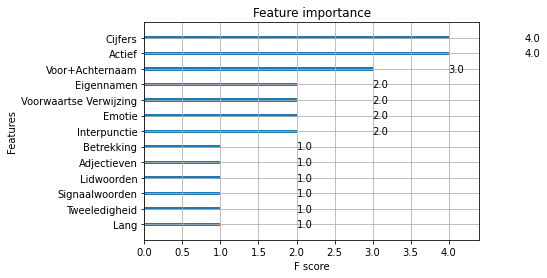

<Figure size 1152x864 with 0 Axes>

In [13]:
import xgboost as xgb
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.figure(figsize=(16, 12))
plt.show()